In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

from local_explanations import *
import utils
import models
import json

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import torch
import torch_geometric.transforms as T
from torch_geometric.utils import from_networkx, to_networkx

%load_ext autoreload
%autoreload 2

### Read hyper-parameters and data

In [8]:
DATASET_NAME = "Mutagenicity"

with open("../config/" + DATASET_NAME + "_params.json") as json_file:
    hyper_params = json.load(json_file)

In [2]:
adjs_train , \
edge_weights_train , \
ori_adjs_train , \
ori_classes_train , \
belonging_train , \
summary_predictions_train , \
le_classes_train ,\
embeddings_train = read_mutagenicity(evaluate_method=False, 
                                     manual_cut=0.37731856, #0.42392886
                                     split="TRAIN")

print(np.unique(le_classes_train, return_counts=True))

belonging_train2 = np.array(belonging_train)
le_classes_train = np.array(le_classes_train)
c = 0
for b in np.unique(belonging_train):
    if ori_classes_train[b] == 1 and 0 in le_classes_train[belonging_train2 == b]:
        c += 1
print("Samples of class 1 containing NO2: ", c/len(ori_classes_train))
c = 0
for b in np.unique(belonging_train):
    if ori_classes_train[b] == 0 and 0 not in le_classes_train[belonging_train2 == b]:
        c += 1
print("Samples of class 0 not containing NO2: ", c/len(ori_classes_train))

print(len(adjs_train) , len(edge_weights_train), len(ori_adjs_train) , len(ori_classes_train) , len(belonging_train))
np.unique(summary_predictions_train["wrong"], return_counts=True) , np.unique(summary_predictions_train["correct"], return_counts=True)

This is a NH2 local explanation
This is a NH2 local explanation
(array([0, 1]), array([675, 451], dtype=int64))
Samples of class 1 containing NO2:  0.050188205771643665
Samples of class 0 not containing NO2:  0.13801756587202008
1126 1126 797 797 1126


((array([], dtype=float64), array([], dtype=int64)),
 (array([0, 1]), array([1921, 1548], dtype=int64)))

In [3]:
adjs_val , \
edge_weights_val , \
ori_adjs_val , \
ori_classes_val , \
belonging_val , \
summary_predictions_val , \
le_classes_val ,\
embeddings_val = read_mutagenicity(evaluate_method=False, 
                                   manual_cut=0.37731856,
                                   split="VAL")

print(np.unique(le_classes_val, return_counts=True))

belonging_val2 = np.array(belonging_val)
le_classes_val = np.array(le_classes_val)
c = 0
for b in np.unique(belonging_val):
    if ori_classes_val[b] == 1 and 0 in le_classes_val[belonging_val2 == b]:
        c += 1
print("Samples of class 1 containing NO2: ", c/len(ori_classes_val))
c = 0
for b in np.unique(belonging_val):
    if ori_classes_val[b] == 0 and 0 not in le_classes_val[belonging_val2 == b]:
        c += 1
print("Samples of class 0 not containing NO2: ", c/len(ori_classes_val))

print(len(adjs_val) , len(edge_weights_val), len(ori_adjs_val) , len(ori_classes_val) , len(belonging_val))
np.unique(summary_predictions_val["wrong"], return_counts=True) , np.unique(summary_predictions_val["correct"], return_counts=True)

(array([0, 1]), array([93, 62], dtype=int64))
Samples of class 1 containing NO2:  0.01904761904761905
Samples of class 0 not containing NO2:  0.17142857142857143
155 155 105 105 155


((array([], dtype=float64), array([], dtype=int64)),
 (array([0, 1]), array([245, 189], dtype=int64)))

In [4]:
adjs_test , \
edge_weights_test , \
ori_adjs_test , \
ori_classes_test , \
belonging_test , \
summary_predictions_test , \
le_classes_test ,\
embeddings_test = read_mutagenicity(evaluate_method=False, 
                                   manual_cut=0.37731856,
                                   split="TEST")

print(np.unique(le_classes_test, return_counts=True))

belonging_test2 = np.array(belonging_test)
le_classes_test = np.array(le_classes_test)
c = 0
for b in np.unique(belonging_test):
    if ori_classes_test[b] == 1 and 0 in le_classes_test[belonging_test2 == b]:
        c += 1
print("Samples of class 1 containing NO2: ", c/len(ori_classes_test))
c = 0
for b in np.unique(belonging_test):
    if ori_classes_test[b] == 0 and 0 not in le_classes_test[belonging_test2 == b]:
        c += 1
print("Samples of class 0 not containing NO2: ", c/len(ori_classes_test))

print(len(adjs_test) , len(edge_weights_test), len(ori_adjs_test) , len(ori_classes_test) , len(belonging_test))
np.unique(summary_predictions_test["wrong"], return_counts=True) , np.unique(summary_predictions_test["correct"], return_counts=True)

(array([0, 1]), array([74, 65], dtype=int64))
Samples of class 1 containing NO2:  0.02040816326530612
Samples of class 0 not containing NO2:  0.17346938775510204
139 139 98 98 139


((array([], dtype=float64), array([], dtype=int64)),
 (array([0, 1]), array([235, 199], dtype=int64)))

(array([0, 1]), array([675, 451], dtype=int64))
(tensor([0, 1]), tensor([837, 289]))


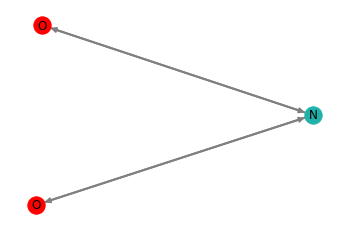

(15, tensor([15]))

In [6]:
device = "cpu" #torch.device('cuda' if torch.cuda.is_available() else 'cpu')
transform = None

dataset_train = utils.LocalExplanationsDataset("", adjs_train, edge_weights_test, "embeddings", transform=transform, y=le_classes_train, belonging=belonging_train, task_y=ori_classes_train, precomputed_embeddings=embeddings_train)
dataset_val   = utils.LocalExplanationsDataset("", adjs_val, edge_weights_val, "embeddings", transform=transform, y=le_classes_val, belonging=belonging_val, task_y=ori_classes_val, precomputed_embeddings=embeddings_val)
dataset_test  = utils.LocalExplanationsDataset("", adjs_test, edge_weights_test, "embeddings", transform=transform, y=le_classes_test, belonging=belonging_test, task_y=ori_classes_test, precomputed_embeddings=embeddings_test)

### Train GLGExplainer

(array([0., 1.], dtype=float32), array([675, 451], dtype=int64))
[0.8435136  0.10110801]


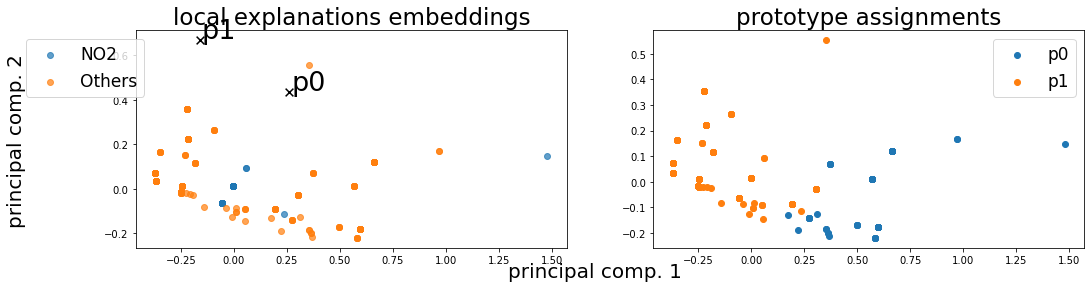

Alpha norms:
tensor([[1.0000, 0.6722],
        [0.7495, 1.0000]])
Concept Purity: 0.848798 +- 0.145249
Concept distribution:  (array([0, 1], dtype=int64), array([168, 958], dtype=int64))
Logic formulas:
For class 0:
0.0 ()
For class 1:
0.0 ()
Accuracy as classifier:  0.0
LEN fidelity:  tensor(0.)

  1: Loss: 0.16914, LEN: 0.067577, AccxC: 0.27, AccO: 0.00, V. Acc: 0.00, V. Loss: 0.19108, V. LEN 0.09
  2: Loss: 0.13664, LEN: 0.067317, AccxC: 0.75, AccO: 0.00, V. Acc: 0.00, V. Loss: 0.16226, V. LEN 0.09
  3: Loss: 0.11553, LEN: 0.067085, AccxC: 0.75, AccO: 0.00, V. Acc: 0.00, V. Loss: 0.14404, V. LEN 0.09
  4: Loss: 0.09352, LEN: 0.066858, AccxC: 0.75, AccO: 0.00, V. Acc: 0.00, V. Loss: 0.11209, V. LEN 0.09
  5: Loss: 0.07810, LEN: 0.066632, AccxC: 0.75, AccO: 0.00, V. Acc: 0.73, V. Loss: 0.10390, V. LEN 0.09
  6: Loss: 0.07527, LEN: 0.066423, AccxC: 0.75, AccO: 0.69, V. Acc: 0.75, V. Loss: 0.09484, V. LEN 0.08
  7: Loss: 0.07253, LEN: 0.066238, AccxC: 0.75, AccO: 0.69, V. Acc: 0.75, V. 

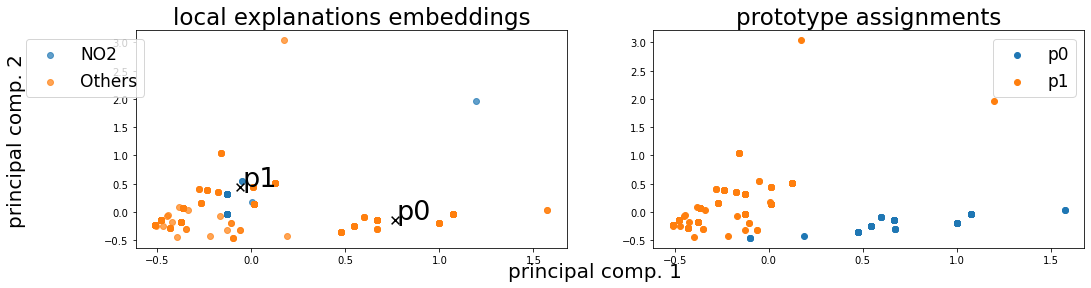

Alpha norms:
tensor([[1.0000, 0.9861],
        [0.7421, 1.0000]])
Concept Purity: 0.853403 +- 0.146597
Concept distribution:  (array([0, 1], dtype=int64), array([171, 955], dtype=int64))
Logic formulas:
For class 0:
0.7716436637390214 ((feature001) | ((feature001 & feature000)
For class 1:
0.0 ()
Accuracy as classifier:  0.0
LEN fidelity:  tensor(0.6976)


 20: Loss: 0.06347, LEN: 0.061684, AccxC: 0.77, AccO: 0.70, V. Acc: 0.75, V. Loss: 0.08091, V. LEN 0.08
 21: Loss: 0.06327, LEN: 0.061220, AccxC: 0.77, AccO: 0.70, V. Acc: 0.75, V. Loss: 0.07973, V. LEN 0.08
 22: Loss: 0.06286, LEN: 0.060954, AccxC: 0.77, AccO: 0.70, V. Acc: 0.75, V. Loss: 0.07946, V. LEN 0.08
 23: Loss: 0.06253, LEN: 0.060831, AccxC: 0.76, AccO: 0.70, V. Acc: 0.75, V. Loss: 0.08068, V. LEN 0.08
 24: Loss: 0.06511, LEN: 0.060438, AccxC: 0.77, AccO: 0.70, V. Acc: 0.75, V. Loss: 0.07980, V. LEN 0.08
 25: Loss: 0.06142, LEN: 0.060148, AccxC: 0.77, AccO: 0.70, V. Acc: 0.75, V. Loss: 0.07880, V. LEN 0.08
 26: Loss: 0.0610

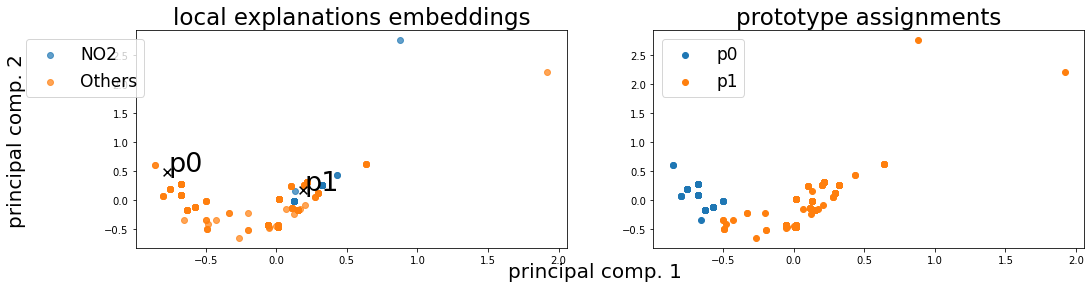

Alpha norms:
tensor([[0.7659, 1.0000],
        [0.8109, 1.0000]])
Concept Purity: 0.852296 +- 0.147704
Concept distribution:  (array([0, 1], dtype=int64), array([168, 958], dtype=int64))
Logic formulas:
For class 0:
0.7703889585947302 (feature001) | ((feature000 & feature001)
For class 1:
0.0 ()
Accuracy as classifier:  0.0
LEN fidelity:  tensor(0.6976)


 40: Loss: 0.05669, LEN: 0.055997, AccxC: 0.77, AccO: 0.70, V. Acc: 0.75, V. Loss: 0.07295, V. LEN 0.07
 41: Loss: 0.05567, LEN: 0.054961, AccxC: 0.77, AccO: 0.70, V. Acc: 0.75, V. Loss: 0.07179, V. LEN 0.07
 42: Loss: 0.05579, LEN: 0.055136, AccxC: 0.77, AccO: 0.70, V. Acc: 0.75, V. Loss: 0.07099, V. LEN 0.07
 43: Loss: 0.05511, LEN: 0.054446, AccxC: 0.77, AccO: 0.70, V. Acc: 0.75, V. Loss: 0.07166, V. LEN 0.07
 44: Loss: 0.05582, LEN: 0.055128, AccxC: 0.77, AccO: 0.70, V. Acc: 0.75, V. Loss: 0.07153, V. LEN 0.07
 45: Loss: 0.05479, LEN: 0.054143, AccxC: 0.77, AccO: 0.70, V. Acc: 0.75, V. Loss: 0.07001, V. LEN 0.07
 46: Loss: 0.05447

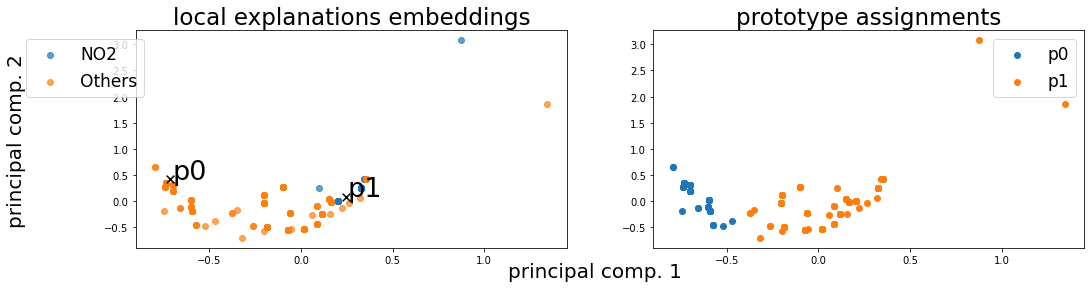

Alpha norms:
tensor([[0.6946, 1.0000],
        [1.0000, 0.8794]])
Concept Purity: 0.854890 +- 0.145110
Concept distribution:  (array([0, 1], dtype=int64), array([175, 951], dtype=int64))
Logic formulas:
For class 0:
0.7741530740276035 (feature001) | ((feature000 & feature001)
For class 1:
0.0 ()
Accuracy as classifier:  0.0
LEN fidelity:  tensor(0.6976)


 60: Loss: 0.05388, LEN: 0.053191, AccxC: 0.77, AccO: 0.70, V. Acc: 0.75, V. Loss: 0.06626, V. LEN 0.07
 61: Loss: 0.05284, LEN: 0.052168, AccxC: 0.77, AccO: 0.69, V. Acc: 0.75, V. Loss: 0.06657, V. LEN 0.07
 62: Loss: 0.05162, LEN: 0.051055, AccxC: 0.79, AccO: 0.69, V. Acc: 0.70, V. Loss: 0.06648, V. LEN 0.06
 63: Loss: 0.05112, LEN: 0.050290, AccxC: 0.78, AccO: 0.69, V. Acc: 0.75, V. Loss: 0.06577, V. LEN 0.06
 64: Loss: 0.05277, LEN: 0.052244, AccxC: 0.78, AccO: 0.69, V. Acc: 0.75, V. Loss: 0.06472, V. LEN 0.06
 65: Loss: 0.05402, LEN: 0.053614, AccxC: 0.78, AccO: 0.69, V. Acc: 0.71, V. Loss: 0.06422, V. LEN 0.06
 66: Loss: 0.05042

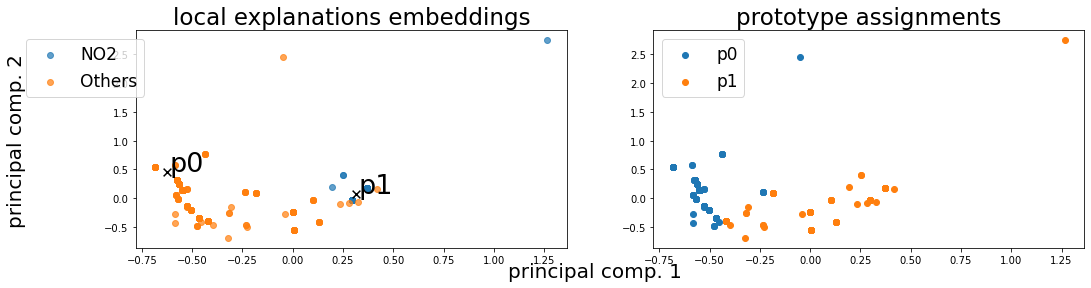

Alpha norms:
tensor([[0.6610, 1.0000],
        [1.0000, 0.5531]])
Concept Purity: 0.955466 +- 0.044534
Concept distribution:  (array([0, 1], dtype=int64), array([385, 741], dtype=int64))
Logic formulas:
For class 0:
0.8180677540777918 (feature001) | ((feature000 & feature001)
For class 1:
0.8180677540777918 (feature000)
Accuracy as classifier:  0.8181
LEN fidelity:  tensor(0.8181)


 80: Loss: 0.04522, LEN: 0.044860, AccxC: 0.81, AccO: 0.81, V. Acc: 0.82, V. Loss: 0.05570, V. LEN 0.05
 81: Loss: 0.04535, LEN: 0.044829, AccxC: 0.80, AccO: 0.80, V. Acc: 0.82, V. Loss: 0.05524, V. LEN 0.05
 82: Loss: 0.04427, LEN: 0.043808, AccxC: 0.81, AccO: 0.81, V. Acc: 0.82, V. Loss: 0.05567, V. LEN 0.05
 83: Loss: 0.04232, LEN: 0.041841, AccxC: 0.82, AccO: 0.82, V. Acc: 0.82, V. Loss: 0.05424, V. LEN 0.05
 84: Loss: 0.04356, LEN: 0.042866, AccxC: 0.81, AccO: 0.81, V. Acc: 0.82, V. Loss: 0.05426, V. LEN 0.05
 85: Loss: 0.04297, LEN: 0.042620, AccxC: 0.82, AccO: 0.82, V. Acc: 0.82, V. Loss: 0.05412, V.

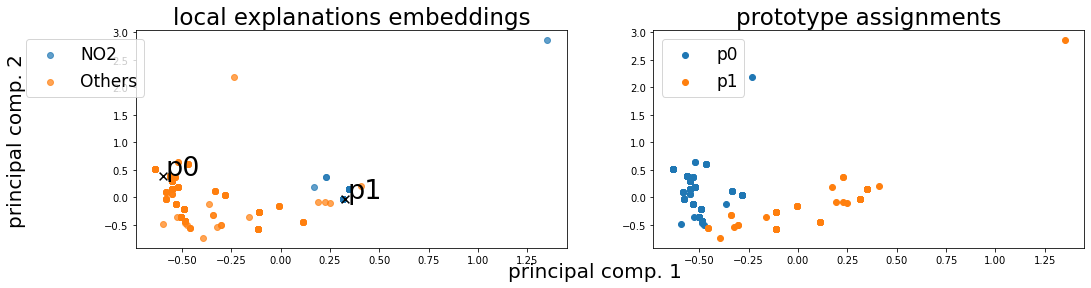

Alpha norms:
tensor([[0.7211, 1.0000],
        [1.0000, 0.4709]])
Concept Purity: 0.967452 +- 0.032548
Concept distribution:  (array([0, 1], dtype=int64), array([404, 722], dtype=int64))
Logic formulas:
For class 0:
0.820577164366374 (feature001) | ((feature000 & feature001)
For class 1:
0.820577164366374 (feature000)
Accuracy as classifier:  0.8206
LEN fidelity:  tensor(0.8206)


100: Loss: 0.04042, LEN: 0.039907, AccxC: 0.81, AccO: 0.81, V. Acc: 0.82, V. Loss: 0.05162, V. LEN 0.05
101: Loss: 0.04270, LEN: 0.042277, AccxC: 0.82, AccO: 0.82, V. Acc: 0.82, V. Loss: 0.05174, V. LEN 0.05
102: Loss: 0.04088, LEN: 0.040499, AccxC: 0.81, AccO: 0.81, V. Acc: 0.82, V. Loss: 0.05216, V. LEN 0.05
103: Loss: 0.04165, LEN: 0.041302, AccxC: 0.81, AccO: 0.81, V. Acc: 0.82, V. Loss: 0.05206, V. LEN 0.05
104: Loss: 0.04088, LEN: 0.040511, AccxC: 0.82, AccO: 0.82, V. Acc: 0.82, V. Loss: 0.05192, V. LEN 0.05
105: Loss: 0.04098, LEN: 0.040581, AccxC: 0.82, AccO: 0.82, V. Acc: 0.82, V. Loss: 0.05335, V. L

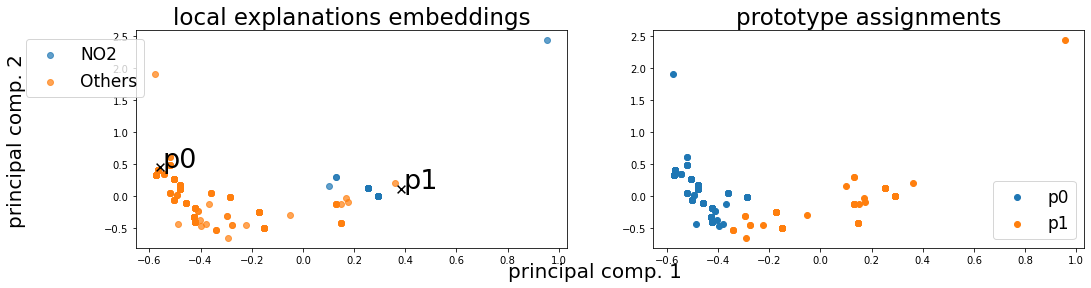

Alpha norms:
tensor([[0.8241, 1.0000],
        [1.0000, 0.4368]])
Concept Purity: 0.967452 +- 0.032548
Concept distribution:  (array([0, 1], dtype=int64), array([404, 722], dtype=int64))
Logic formulas:
For class 0:
0.820577164366374 (feature001) | ((feature000 & feature001)
For class 1:
0.820577164366374 (feature000)
Accuracy as classifier:  0.8206
LEN fidelity:  tensor(0.8206)


120: Loss: 0.04382, LEN: 0.043473, AccxC: 0.82, AccO: 0.82, V. Acc: 0.82, V. Loss: 0.05220, V. LEN 0.05
121: Loss: 0.04080, LEN: 0.040422, AccxC: 0.82, AccO: 0.82, V. Acc: 0.81, V. Loss: 0.05392, V. LEN 0.05
122: Loss: 0.04252, LEN: 0.042226, AccxC: 0.81, AccO: 0.81, V. Acc: 0.81, V. Loss: 0.05328, V. LEN 0.05
123: Loss: 0.04326, LEN: 0.042910, AccxC: 0.81, AccO: 0.81, V. Acc: 0.82, V. Loss: 0.05192, V. LEN 0.05
124: Loss: 0.03983, LEN: 0.039502, AccxC: 0.83, AccO: 0.83, V. Acc: 0.82, V. Loss: 0.05213, V. LEN 0.05
125: Loss: 0.04130, LEN: 0.040966, AccxC: 0.82, AccO: 0.82, V. Acc: 0.82, V. Loss: 0.05201, V. L

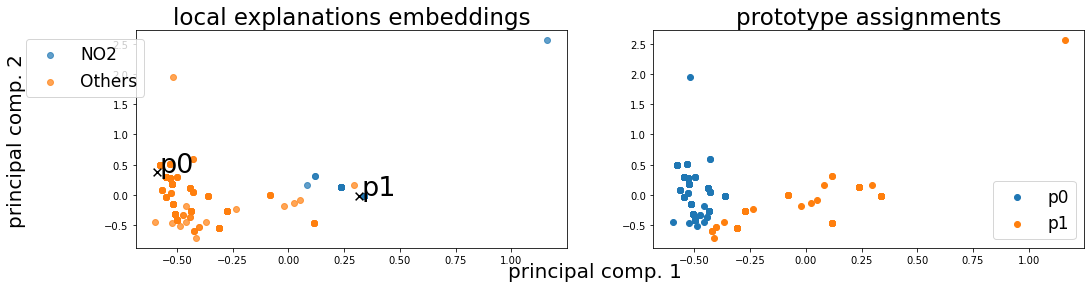

Alpha norms:
tensor([[0.8794, 1.0000],
        [1.0000, 0.4120]])
Concept Purity: 0.968750 +- 0.031250
Concept distribution:  (array([0, 1], dtype=int64), array([406, 720], dtype=int64))
Logic formulas:
For class 0:
0.8180677540777918 (feature001) | ((feature000 & feature001)
For class 1:
0.8180677540777918 (feature000)
Accuracy as classifier:  0.8181
LEN fidelity:  tensor(0.8181)


140: Loss: 0.04228, LEN: 0.042001, AccxC: 0.81, AccO: 0.81, V. Acc: 0.81, V. Loss: 0.05240, V. LEN 0.05
141: Loss: 0.04071, LEN: 0.040428, AccxC: 0.82, AccO: 0.82, V. Acc: 0.81, V. Loss: 0.05276, V. LEN 0.05
142: Loss: 0.04121, LEN: 0.040898, AccxC: 0.82, AccO: 0.82, V. Acc: 0.81, V. Loss: 0.05272, V. LEN 0.05
143: Loss: 0.03957, LEN: 0.039270, AccxC: 0.82, AccO: 0.82, V. Acc: 0.81, V. Loss: 0.05307, V. LEN 0.05
144: Loss: 0.04258, LEN: 0.042301, AccxC: 0.81, AccO: 0.81, V. Acc: 0.81, V. Loss: 0.05324, V. LEN 0.05
145: Loss: 0.04251, LEN: 0.042248, AccxC: 0.82, AccO: 0.82, V. Acc: 0.82, V. Loss: 0.05200, V.

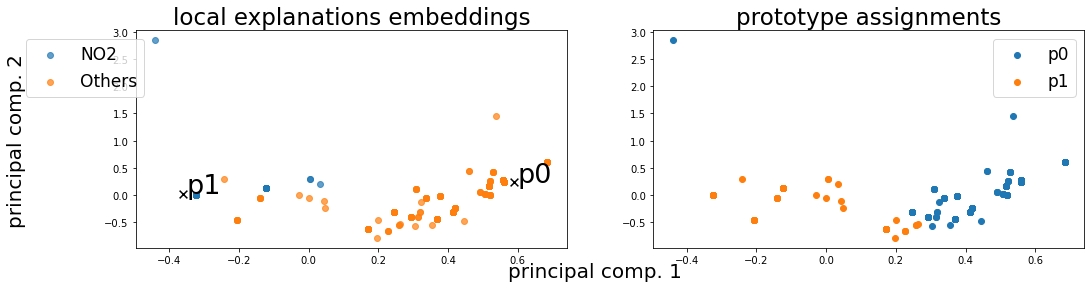

Alpha norms:
tensor([[0.9110, 1.0000],
        [1.0000, 0.3955]])
Concept Purity: 0.974793 +- 0.022815
Concept distribution:  (array([0, 1], dtype=int64), array([418, 708], dtype=int64))
Logic formulas:
For class 0:
0.8105395232120451 (feature001) | ((feature000 & feature001)
For class 1:
0.8105395232120451 (feature000)
Accuracy as classifier:  0.8105
LEN fidelity:  tensor(0.8105)


160: Loss: 0.04101, LEN: 0.040658, AccxC: 0.81, AccO: 0.81, V. Acc: 0.82, V. Loss: 0.04956, V. LEN 0.05
161: Loss: 0.04273, LEN: 0.042418, AccxC: 0.81, AccO: 0.81, V. Acc: 0.81, V. Loss: 0.05206, V. LEN 0.05
162: Loss: 0.04104, LEN: 0.040763, AccxC: 0.81, AccO: 0.81, V. Acc: 0.81, V. Loss: 0.05328, V. LEN 0.05
163: Loss: 0.04206, LEN: 0.041795, AccxC: 0.83, AccO: 0.83, V. Acc: 0.82, V. Loss: 0.05271, V. LEN 0.05
164: Loss: 0.04373, LEN: 0.043406, AccxC: 0.81, AccO: 0.81, V. Acc: 0.82, V. Loss: 0.05250, V. LEN 0.05
165: Loss: 0.04086, LEN: 0.040532, AccxC: 0.81, AccO: 0.81, V. Acc: 0.81, V. Loss: 0.05350, V.

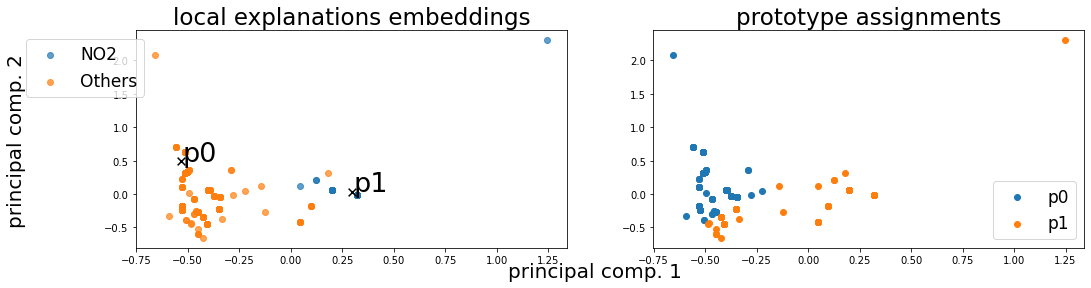

Alpha norms:
tensor([[0.9666, 1.0000],
        [1.0000, 0.3710]])
Concept Purity: 0.963599 +- 0.036401
Concept distribution:  (array([0, 1], dtype=int64), array([398, 728], dtype=int64))
Logic formulas:
For class 0:
0.8130489335006273 (feature001) | ((feature000 & feature001)
For class 1:
0.8130489335006273 (feature000)
Accuracy as classifier:  0.813
LEN fidelity:  tensor(0.8130)


180: Loss: 0.04203, LEN: 0.041622, AccxC: 0.80, AccO: 0.80, V. Acc: 0.80, V. Loss: 0.05546, V. LEN 0.05
181: Loss: 0.04233, LEN: 0.041290, AccxC: 0.81, AccO: 0.81, V. Acc: 0.81, V. Loss: 0.05574, V. LEN 0.05
182: Loss: 0.04197, LEN: 0.041571, AccxC: 0.82, AccO: 0.82, V. Acc: 0.80, V. Loss: 0.05534, V. LEN 0.05
183: Loss: 0.04161, LEN: 0.041323, AccxC: 0.81, AccO: 0.81, V. Acc: 0.80, V. Loss: 0.05512, V. LEN 0.05
184: Loss: 0.04276, LEN: 0.041996, AccxC: 0.81, AccO: 0.81, V. Acc: 0.80, V. Loss: 0.05669, V. LEN 0.06
185: Loss: 0.04031, LEN: 0.040031, AccxC: 0.81, AccO: 0.81, V. Acc: 0.80, V. Loss: 0.05521, V. 

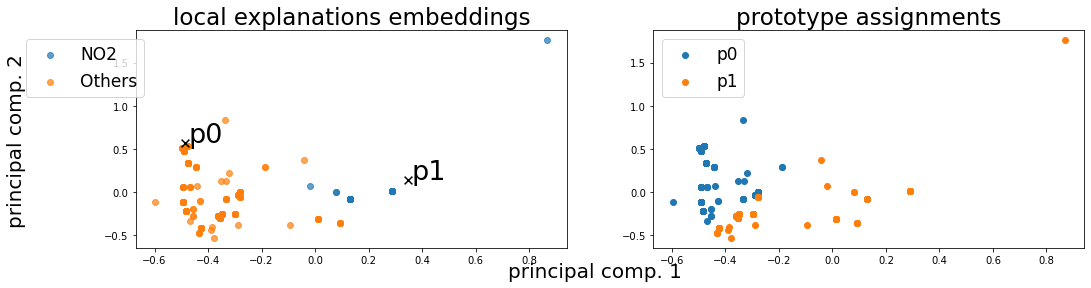

Alpha norms:
tensor([[1.0000, 0.9815],
        [1.0000, 0.3584]])
Concept Purity: 0.951807 +- 0.048193
Concept distribution:  (array([0, 1], dtype=int64), array([379, 747], dtype=int64))
Logic formulas:
For class 0:
0.8180677540777918 ((feature001) | ((feature001 & feature000)
For class 1:
0.8180677540777918 (feature000)
Accuracy as classifier:  0.8181
LEN fidelity:  tensor(0.8181)


200: Loss: 0.04221, LEN: 0.041929, AccxC: 0.81, AccO: 0.81, V. Acc: 0.80, V. Loss: 0.05721, V. LEN 0.06
201: Loss: 0.03982, LEN: 0.039578, AccxC: 0.83, AccO: 0.83, V. Acc: 0.80, V. Loss: 0.05667, V. LEN 0.06
202: Loss: 0.04159, LEN: 0.041310, AccxC: 0.82, AccO: 0.82, V. Acc: 0.81, V. Loss: 0.05280, V. LEN 0.05
203: Loss: 0.04284, LEN: 0.042611, AccxC: 0.81, AccO: 0.81, V. Acc: 0.81, V. Loss: 0.05297, V. LEN 0.05
204: Loss: 0.04107, LEN: 0.040722, AccxC: 0.82, AccO: 0.82, V. Acc: 0.81, V. Loss: 0.05452, V. LEN 0.05
205: Loss: 0.03894, LEN: 0.038735, AccxC: 0.82, AccO: 0.82, V. Acc: 0.80, V. Loss: 0.05690, V

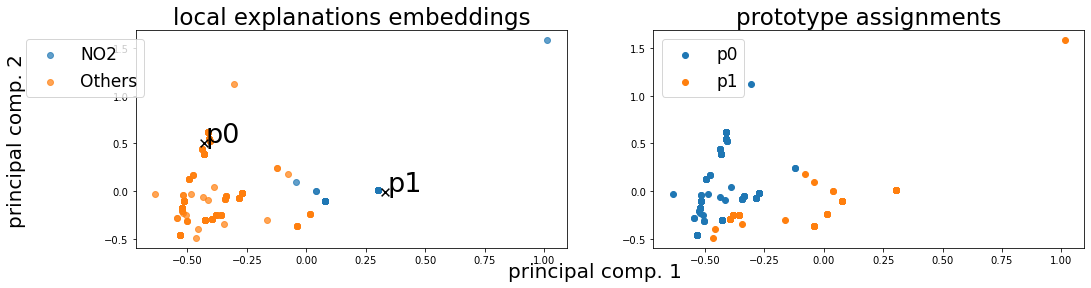

Alpha norms:
tensor([[1.0000, 0.9643],
        [1.0000, 0.3596]])
Concept Purity: 0.971369 +- 0.028631
Concept distribution:  (array([0, 1], dtype=int64), array([410, 716], dtype=int64))
Logic formulas:
For class 0:
0.8193224592220828 ((feature001) | ((feature001 & feature000)
For class 1:
0.8193224592220828 (feature000)
Accuracy as classifier:  0.8193
LEN fidelity:  tensor(0.8193)


220: Loss: 0.04275, LEN: 0.042432, AccxC: 0.81, AccO: 0.81, V. Acc: 0.82, V. Loss: 0.05158, V. LEN 0.05
221: Loss: 0.04069, LEN: 0.040333, AccxC: 0.82, AccO: 0.82, V. Acc: 0.81, V. Loss: 0.05806, V. LEN 0.06
222: Loss: 0.04345, LEN: 0.042968, AccxC: 0.81, AccO: 0.81, V. Acc: 0.81, V. Loss: 0.05817, V. LEN 0.06
223: Loss: 0.04207, LEN: 0.040532, AccxC: 0.82, AccO: 0.82, V. Acc: 0.81, V. Loss: 0.05815, V. LEN 0.06
224: Loss: 0.04173, LEN: 0.041380, AccxC: 0.82, AccO: 0.82, V. Acc: 0.81, V. Loss: 0.05292, V. LEN 0.05
225: Loss: 0.03936, LEN: 0.038084, AccxC: 0.82, AccO: 0.82, V. Acc: 0.83, V. Loss: 0.04813, V

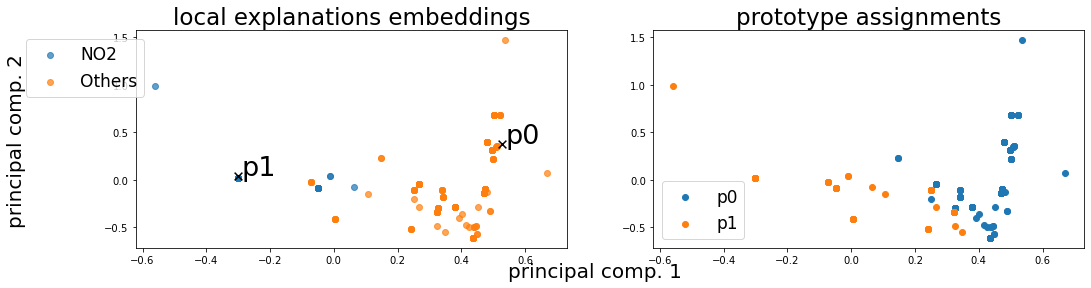

Alpha norms:
tensor([[1.0000, 0.9540],
        [1.0000, 0.3715]])
Concept Purity: 0.974017 +- 0.025983
Concept distribution:  (array([0, 1], dtype=int64), array([414, 712], dtype=int64))
Logic formulas:
For class 0:
0.8168130489335006 ((feature001) | ((feature001 & feature000)
For class 1:
0.8168130489335006 (feature000)
Accuracy as classifier:  0.8168
LEN fidelity:  tensor(0.8168)


240: Loss: 0.04072, LEN: 0.040395, AccxC: 0.82, AccO: 0.82, V. Acc: 0.82, V. Loss: 0.04990, V. LEN 0.05
241: Loss: 0.03886, LEN: 0.038640, AccxC: 0.83, AccO: 0.83, V. Acc: 0.81, V. Loss: 0.05263, V. LEN 0.05
242: Loss: 0.04093, LEN: 0.040674, AccxC: 0.81, AccO: 0.81, V. Acc: 0.81, V. Loss: 0.05262, V. LEN 0.05
243: Loss: 0.04057, LEN: 0.040370, AccxC: 0.83, AccO: 0.83, V. Acc: 0.82, V. Loss: 0.05589, V. LEN 0.06
244: Loss: 0.04298, LEN: 0.042744, AccxC: 0.82, AccO: 0.82, V. Acc: 0.82, V. Loss: 0.05601, V. LEN 0.06
245: Loss: 0.04293, LEN: 0.042614, AccxC: 0.82, AccO: 0.82, V. Acc: 0.81, V. Loss: 0.05287, V

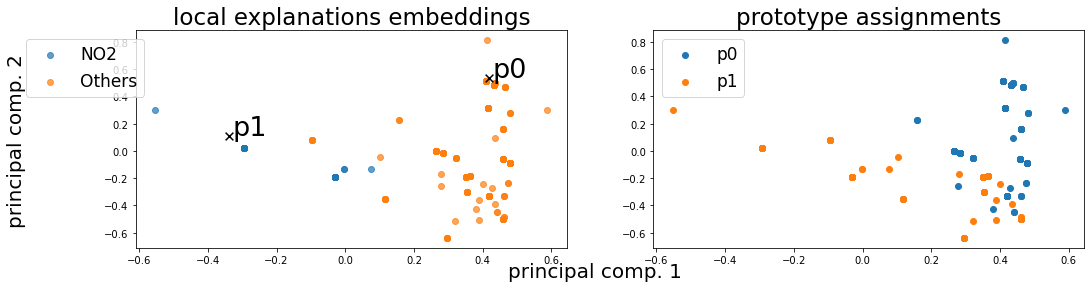

Alpha norms:
tensor([[1.0000, 0.9388],
        [1.0000, 0.3689]])
Concept Purity: 0.959184 +- 0.040816
Concept distribution:  (array([0, 1], dtype=int64), array([391, 735], dtype=int64))
Logic formulas:
For class 0:
0.820577164366374 ((feature001) | ((feature001 & feature000)
For class 1:
0.820577164366374 (feature000)
Accuracy as classifier:  0.8206
LEN fidelity:  tensor(0.8206)


260: Loss: 0.03974, LEN: 0.039507, AccxC: 0.82, AccO: 0.82, V. Acc: 0.81, V. Loss: 0.05450, V. LEN 0.05
261: Loss: 0.03981, LEN: 0.039587, AccxC: 0.82, AccO: 0.82, V. Acc: 0.81, V. Loss: 0.05413, V. LEN 0.05
262: Loss: 0.03841, LEN: 0.037977, AccxC: 0.84, AccO: 0.84, V. Acc: 0.81, V. Loss: 0.05417, V. LEN 0.05
263: Loss: 0.04106, LEN: 0.040861, AccxC: 0.82, AccO: 0.82, V. Acc: 0.82, V. Loss: 0.05079, V. LEN 0.05
264: Loss: 0.04043, LEN: 0.040173, AccxC: 0.82, AccO: 0.82, V. Acc: 0.81, V. Loss: 0.05543, V. LEN 0.05
265: Loss: 0.04097, LEN: 0.039684, AccxC: 0.82, AccO: 0.82, V. Acc: 0.81, V. Loss: 0.05465, V. 

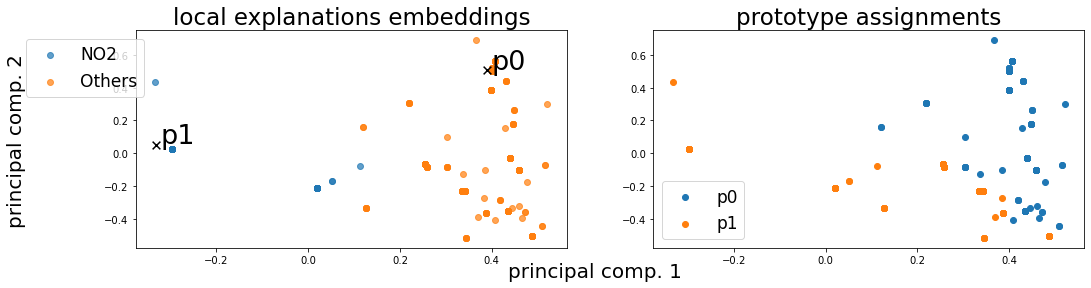

Alpha norms:
tensor([[1.0000, 0.9371],
        [1.0000, 0.3729]])
Concept Purity: 0.901308 +- 0.098692
Concept distribution:  (array([0, 1], dtype=int64), array([285, 841], dtype=int64))
Logic formulas:
For class 0:
0.820577164366374 ((feature001) | ((feature001 & feature000)
For class 1:
0.820577164366374 (feature000)
Accuracy as classifier:  0.8206
LEN fidelity:  tensor(0.8206)


280: Loss: 0.03968, LEN: 0.039411, AccxC: 0.82, AccO: 0.82, V. Acc: 0.82, V. Loss: 0.05560, V. LEN 0.06
281: Loss: 0.03960, LEN: 0.039140, AccxC: 0.82, AccO: 0.82, V. Acc: 0.81, V. Loss: 0.05831, V. LEN 0.06
282: Loss: 0.04307, LEN: 0.042867, AccxC: 0.81, AccO: 0.81, V. Acc: 0.80, V. Loss: 0.05685, V. LEN 0.06
283: Loss: 0.04081, LEN: 0.040561, AccxC: 0.82, AccO: 0.82, V. Acc: 0.81, V. Loss: 0.05428, V. LEN 0.05
284: Loss: 0.04170, LEN: 0.041342, AccxC: 0.82, AccO: 0.82, V. Acc: 0.81, V. Loss: 0.05400, V. LEN 0.05
285: Loss: 0.03964, LEN: 0.039429, AccxC: 0.81, AccO: 0.81, V. Acc: 0.80, V. Loss: 0.05660, V. 

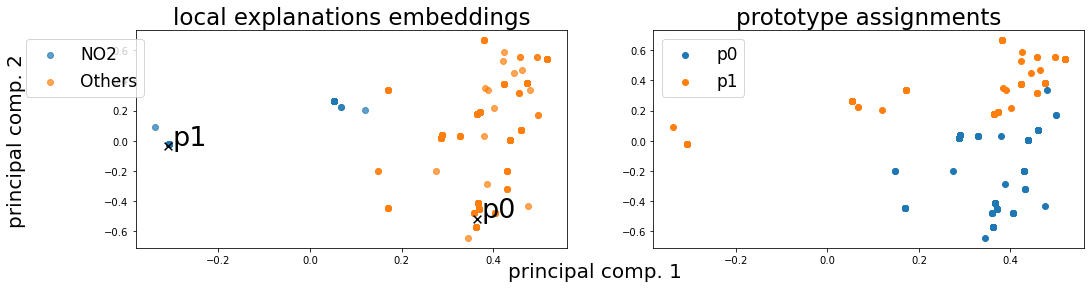

Alpha norms:
tensor([[1.0000, 0.9243],
        [1.0000, 0.3792]])
Concept Purity: 0.951807 +- 0.048193
Concept distribution:  (array([0, 1], dtype=int64), array([379, 747], dtype=int64))
Logic formulas:
For class 0:
0.821831869510665 ((feature001) | ((feature001 & feature000)
For class 1:
0.821831869510665 (feature000)
Accuracy as classifier:  0.8218
LEN fidelity:  tensor(0.8218)


300: Loss: 0.04242, LEN: 0.042196, AccxC: 0.82, AccO: 0.82, V. Acc: 0.80, V. Loss: 0.05664, V. LEN 0.06
301: Loss: 0.04137, LEN: 0.041113, AccxC: 0.82, AccO: 0.82, V. Acc: 0.81, V. Loss: 0.05798, V. LEN 0.06
302: Loss: 0.04172, LEN: 0.041532, AccxC: 0.83, AccO: 0.83, V. Acc: 0.81, V. Loss: 0.05808, V. LEN 0.06
303: Loss: 0.04229, LEN: 0.042096, AccxC: 0.81, AccO: 0.81, V. Acc: 0.80, V. Loss: 0.05702, V. LEN 0.06
304: Loss: 0.04251, LEN: 0.042325, AccxC: 0.82, AccO: 0.82, V. Acc: 0.80, V. Loss: 0.05672, V. LEN 0.06
305: Loss: 0.04166, LEN: 0.041471, AccxC: 0.83, AccO: 0.83, V. Acc: 0.80, V. Loss: 0.05670, V. 

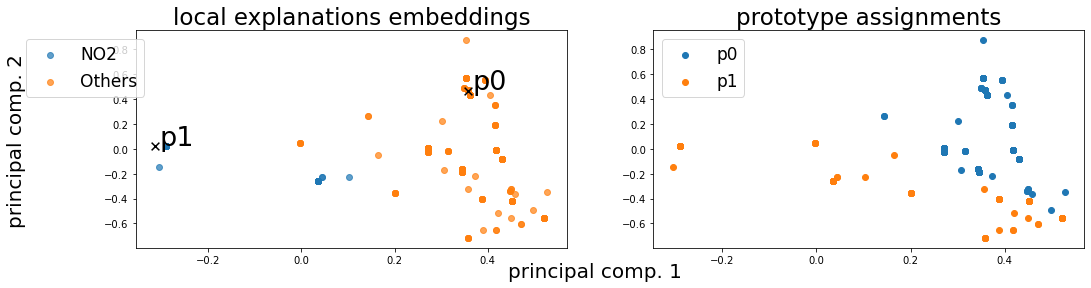

Alpha norms:
tensor([[1.0000, 0.9277],
        [1.0000, 0.3844]])
Concept Purity: 0.962963 +- 0.037037
Concept distribution:  (array([0, 1], dtype=int64), array([397, 729], dtype=int64))
Logic formulas:
For class 0:
0.821831869510665 ((feature001) | ((feature001 & feature000)
For class 1:
0.821831869510665 (feature000)
Accuracy as classifier:  0.8218
LEN fidelity:  tensor(0.8218)


320: Loss: 0.03989, LEN: 0.039685, AccxC: 0.82, AccO: 0.82, V. Acc: 0.81, V. Loss: 0.05404, V. LEN 0.05
321: Loss: 0.03953, LEN: 0.039347, AccxC: 0.82, AccO: 0.82, V. Acc: 0.80, V. Loss: 0.05663, V. LEN 0.06
322: Loss: 0.04076, LEN: 0.040543, AccxC: 0.82, AccO: 0.82, V. Acc: 0.82, V. Loss: 0.05742, V. LEN 0.06
323: Loss: 0.04097, LEN: 0.040752, AccxC: 0.83, AccO: 0.83, V. Acc: 0.81, V. Loss: 0.05606, V. LEN 0.06
324: Loss: 0.04050, LEN: 0.040128, AccxC: 0.83, AccO: 0.83, V. Acc: 0.80, V. Loss: 0.05689, V. LEN 0.06
325: Loss: 0.04248, LEN: 0.041219, AccxC: 0.83, AccO: 0.83, V. Acc: 0.82, V. Loss: 0.05732, V. 

In [9]:
train_group_loader = utils.build_dataloader(dataset_train, belonging_train, num_input_graphs=128)
val_group_loader   = utils.build_dataloader(dataset_val,   belonging_val, num_input_graphs=256)
test_group_loader  = utils.build_dataloader(dataset_test,  belonging_test, num_input_graphs=256)


torch.manual_seed(42)
len_model    = models.LEN(hyper_params["num_prototypes"], 
                          hyper_params["LEN_temperature"], 
                          remove_attention=hyper_params["remove_attention"]).to(device)
le_model     = models.LEEmbedder(num_features=hyper_params["num_le_features"], 
                                 activation=hyper_params["activation"], 
                                 num_hidden=hyper_params["dim_prototypes"]).to(device)
expl         = models.GLGExplainer(len_model, 
                                      le_model, 
                                      train_group_loader, 
                                      val_group_loader, 
                                      device, 
                                      hyper_params=hyper_params,
                                      classes_names=mutag_classes_names,
                                      dataset_name=DATASET_NAME).to(device)

expl.iterate(num_epochs=hyper_params["num_epochs"], plot=True)

(array([0., 1.], dtype=float32), array([74, 65], dtype=int64))
[0.6901984  0.25375375]


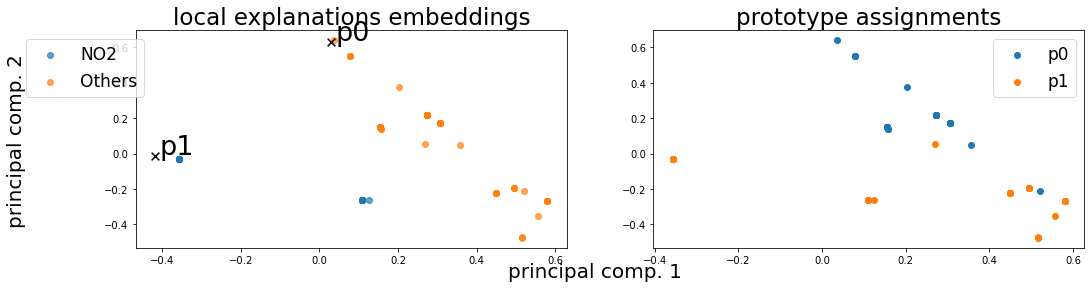

Alpha norms:
tensor([[1.0000, 0.9224],
        [1.0000, 0.3829]])
Concept Purity: 0.911111 +- 0.088889
Concept distribution:  (array([0, 1], dtype=int64), array([49, 90], dtype=int64))
Logic formulas:
For class 0:
0.8061224489795918 ((feature001) | ((feature001 & feature000)
For class 1:
0.8061224489795918 (feature000)
Accuracy as classifier:  0.8061
LEN fidelity:  tensor(0.8061)



In [10]:
expl.inspect_embedding(test_group_loader)

## Load Trained Model

(array([0., 1.], dtype=float32), array([74, 65], dtype=int64))
[0.67841053 0.3154491 ]


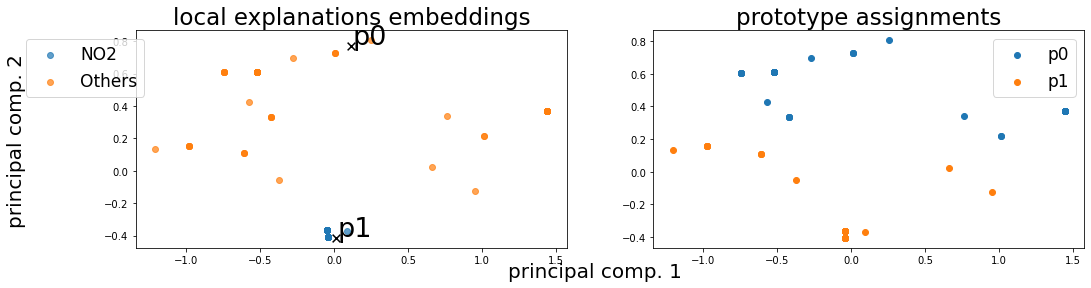

Alpha norms:
tensor([[1.0000, 0.9776],
        [0.4050, 1.0000]])
Concept Purity: 0.930233 +- 0.069767
Concept distribution:  (array([0, 1], dtype=int64), array([53, 86], dtype=int64))
Logic formulas:
For class 0:
0.826530612244898 ((feature001) | ((feature001 & feature000)
For class 1:
0.826530612244898 ((feature000)
Accuracy as classifier:  0.8265
LEN fidelity:  tensor(0.8265)



In [12]:
train_group_loader = utils.build_dataloader(dataset_train, belonging_train, num_input_graphs=128)
val_group_loader   = utils.build_dataloader(dataset_val,   belonging_val, num_input_graphs=256)
test_group_loader  = utils.build_dataloader(dataset_test,  belonging_test, num_input_graphs=256)


torch.manual_seed(42)
len_model2    = models.LEN(hyper_params["num_prototypes"], 
                           hyper_params["LEN_temperature"], 
                           remove_attention=hyper_params["remove_attention"]).to(device)
le_model2     = models.LEEmbedder(num_features=hyper_params["num_le_features"], 
                                  activation=hyper_params["activation"], 
                                  num_hidden=hyper_params["dim_prototypes"]).to(device)
best_expl     = models.GLGExplainer(len_model2, 
                                    le_model2, 
                                    train_group_loader, 
                                    val_group_loader, 
                                    device, 
                                    hyper_params=hyper_params,
                                    classes_names=mutag_classes_names,
                                    dataset_name=DATASET_NAME).to(device)
best_expl.load_state_dict(torch.load("../trained_models/Mutagenicity_allsamples.pt"))
best_expl.eval()

best_expl.inspect_embedding(test_group_loader)

### materialize prototypes

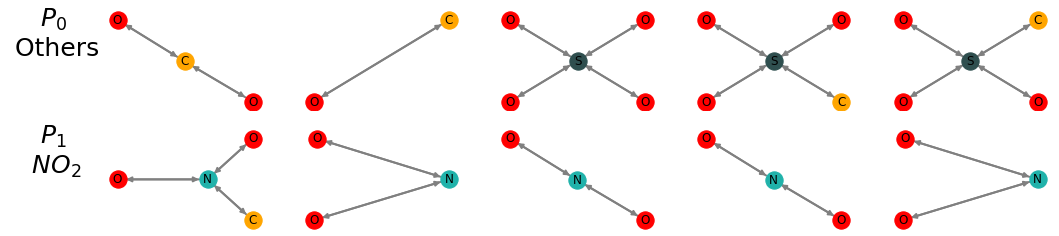

In [16]:
# change assign function to a non-discrete one just to compute distance between local expls. and prototypes
# useful to show the materialization of prototypes based on distance 
best_expl.hyper["assign_func"] = "sim"

x_train , emb , concepts_assignement , y_train_1h , le_classes , le_idxs , belonging = best_expl.get_concept_vector(train_group_loader, 
                                                                                                                    return_raw=True)
best_expl.hyper["assign_func"] = "discrete"

proto_names = {
    0: "Others",
    1: "$NO_2$",
}
torch.manual_seed(42)
fig = plt.figure(figsize=(17,4))
n = 0
for p in range(best_expl.hyper["num_prototypes"]):
    idxs = le_idxs[concepts_assignement.argmax(-1) == p]
    idxs = idxs[torch.randperm(len(idxs))] # for random examples
    sa = concepts_assignement[concepts_assignement.argmax(-1) == p]
    idxs = idxs[torch.argsort(sa[:, p], descending=True)]
    
    for ex in range(5):
        n += 1
        plt.subplot(best_expl.hyper["num_prototypes"],5,n)        
        utils.plot_molecule(dataset_train[int(idxs[ex])], composite_plot=True)

for p in range(best_expl.hyper["num_prototypes"]):
    plt.subplot(best_expl.hyper["num_prototypes"],5,5*p + 1)
    plt.ylabel(f"$P_{p}$\n {proto_names[p]}", size=25, rotation="horizontal", labelpad=50)

plt.show() 